<a href="https://colab.research.google.com/github/hobediente/eCommerce_AB_Test/blob/master/Capstone_1_Oct_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import appropriate libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path= "/content/drive/My Drive/2019-Oct.csv"
df = pd.read_csv(path)

In [0]:
# Get descrip stats 
df.info()
df. head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4102283 entries, 0 to 4102282
Data columns (total 9 columns):
event_time       object
event_type       object
product_id       int64
category_id      int64
category_code    object
brand            object
price            float64
user_id          int64
user_session     object
dtypes: float64(1), int64(3), object(5)
memory usage: 281.7+ MB


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07 UTC,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15 UTC,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


In [0]:
# check for nulls
df.isna().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code    4034806
brand            1659261
price                  0
user_id                0
user_session         637
dtype: int64

In [0]:
# drop columns I don't need
dfd= df.drop(['event_time', 'product_id', 'category_id', 'category_code', 'brand', 'user_session'], axis=1)

In [0]:
# get info on the new columns
dfd.info()
dfd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4102283 entries, 0 to 4102282
Data columns (total 3 columns):
event_type    object
price         float64
user_id       int64
dtypes: float64(1), int64(1), object(1)
memory usage: 93.9+ MB


,event_type,price,user_id
0,cart,2.62,463240011
1,cart,2.62,463240011
2,cart,13.48,429681830
3,cart,2.62,463240011
4,cart,0.56,429681830


Ho: Removing something from a cart and adding something to a cart equally indicate a purchase 


Ha: Removing something from a cart better indicates a purchase than adding something to a cart 

In [0]:
# set every price to 1
dfd.loc[:, 'price']=1
print (dfd)

               event_type  price    user_id
0                    cart      1  463240011
1                    cart      1  463240011
2                    cart      1  429681830
3                    cart      1  463240011
4                    cart      1  429681830
...                   ...    ...        ...
4102278  remove_from_cart      1  429913900
4102279              view      1  556138645
4102280              view      1  564441099
4102281              view      1  429913900
4102282              view      1  566280798

[4102283 rows x 3 columns]


In [0]:
# create new df for pivoted data
dfp= pd.pivot_table(dfd, index='user_id', columns='event_type', values='price', aggfunc='sum')

In [0]:
# reset index
dfp = dfp.reset_index()

In [0]:
dfp.info()
dfp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399664 entries, 0 to 399663
Data columns (total 5 columns):
user_id             399664 non-null int64
cart                133818 non-null float64
purchase            25762 non-null float64
remove_from_cart    47090 non-null float64
view                388331 non-null float64
dtypes: float64(4), int64(1)
memory usage: 15.2 MB


event_type,user_id,cart,purchase,remove_from_cart,view
0,4103071,1.0,NaN,NaN,7.0
1,8846226,24.0,NaN,16.0,7.0
2,9794320,13.0,NaN,4.0,3.0
3,10280338,26.0,NaN,30.0,26.0
4,10702733,NaN,NaN,NaN,2.0


In [0]:
# replace null values with 0
dfp.fillna(value=0, inplace=True)

In [0]:
dfp.head()

event_type,user_id,cart,purchase,remove_from_cart,view
0,4103071,1.0,0.0,0.0,7.0
1,8846226,24.0,0.0,16.0,7.0
2,9794320,13.0,0.0,4.0,3.0
3,10280338,26.0,0.0,30.0,26.0
4,10702733,0.0,0.0,0.0,2.0


In [0]:
# make sure user_id is unique value
dfp['user_id'].value_counts()

564951688    1
555590369    1
559771232    1
476375752    1
557120202    1
            ..
557546949    1
438005191    1
557212401    1
553852361    1
494927872    1
Name: user_id, Length: 399664, dtype: int64

In [0]:
# rename event_type to something else 
dfp.columns = ['user_id', 'cart', 'purchase','remove_from_cart', 'view']

In [0]:
# drop user_id whos cart is = to 0
# bc we are analyzing people who only added to cart v. added and removed from cart 
dfp.drop( dfp[ dfp['cart'] == 0 ].index , inplace=True)

In [0]:
# make sure event_type is gone
dfp.head()

,user_id,cart,purchase,remove_from_cart,view
0,4103071,1.0,0.0,0.0,7.0
1,8846226,24.0,0.0,16.0,7.0
2,9794320,13.0,0.0,4.0,3.0
3,10280338,26.0,0.0,30.0,26.0
5,10968431,1.0,0.0,0.0,1.0


In [0]:
# check out range etc.
dfp.describe()

,user_id,cart,purchase,remove_from_cart,view
count,1.338180e+05,133818.000000,133818.000000,133818.000000,133818.000000
mean,5.259262e+08,9.209411,1.815107,5.598126,9.302672
std,6.757933e+07,20.530637,6.212029,24.428048,27.684004
min,4.103071e+06,1.000000,0.000000,0.000000,0.000000
25%,5.290840e+08,3.000000,0.000000,0.000000,1.000000
50%,5.560754e+08,3.000000,0.000000,0.000000,1.000000
75%,5.576364e+08,8.000000,0.000000,2.000000,7.000000
max,5.662803e+08,1129.000000,329.000000,2783.000000,2124.000000


In [0]:
#assign an extra A/B column for purchase
def buy(purchase):
    if purchase >0:
        return 'yes'
    else:
        return 'no'
dfp['buy']= dfp['purchase'].apply(buy)
dfp.head()

,user_id,cart,purchase,remove_from_cart,view,buy
0,4103071,1.0,0.0,0.0,7.0,no
1,8846226,24.0,0.0,16.0,7.0,no
2,9794320,13.0,0.0,4.0,3.0,no
3,10280338,26.0,0.0,30.0,26.0,no
5,10968431,1.0,0.0,0.0,1.0,no


In [0]:
#assign an extra A/B column for remove_from_cart
def remove(remove_from_cart):
    if remove_from_cart >0:
        return 'yes'
    else:
        return 'no'
dfp['remove']= dfp['remove_from_cart'].apply(remove)
dfp.head()

,user_id,cart,purchase,remove_from_cart,view,buy,remove
0,4103071,1.0,0.0,0.0,7.0,no,no
1,8846226,24.0,0.0,16.0,7.0,no,yes
2,9794320,13.0,0.0,4.0,3.0,no,yes
3,10280338,26.0,0.0,30.0,26.0,no,yes
5,10968431,1.0,0.0,0.0,1.0,no,no


In [0]:
#split data into 2 groups
df_pno= dfp[dfp['purchase']==0]
df_pyes= dfp[dfp['purchase']>0]

In [0]:
# descrip stat
df_pyes.head()

,user_id,cart,purchase,remove_from_cart,view,buy,remove
31,29025780,29.0,18.0,2.0,3.0,yes,yes
40,31229488,7.0,4.0,15.0,27.0,yes,yes
47,33535391,14.0,11.0,4.0,16.0,yes,yes
48,33609704,12.0,9.0,2.0,30.0,yes,yes
53,34080306,11.0,3.0,6.0,22.0,yes,yes


DescribeResult(nobs=25423, minmax=(0.0, 2783.0), mean=16.140896039019786, variance=1935.0014676417368, skewness=17.858056250236654, kurtosis=748.9036325534663)


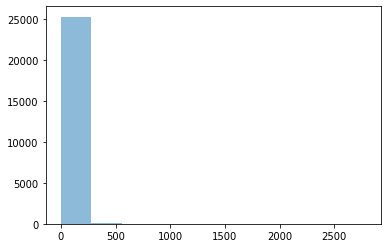

In [0]:
#check distribution of remove_from_cart for both groups
plt.hist(df_pyes['remove_from_cart'], alpha= .5)

print(stats.describe(df_pyes['remove_from_cart']))

DescribeResult(nobs=108395, minmax=(0.0, 843.0), mean=3.1254209142488123, variance=250.68202947276404, skewness=17.250035691581004, kurtosis=510.693102731031)


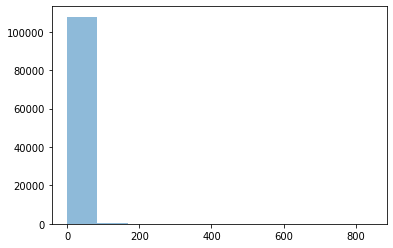

In [0]:
plt.hist(df_pno['remove_from_cart'], alpha= .5)

print(stats.describe(df_pno['remove_from_cart']))

In [0]:
# data is not normally distributed so cannot run ttest--> instead run Kurskal
stats.kruskal(df_pyes['remove_from_cart'], df_pno['remove_from_cart'])

KruskalResult(statistic=31200.044339830914, pvalue=0.0)

In [0]:
# sig difference between means --> reject null hypoth

remove from cart purchase correlation 0.34989706317623726


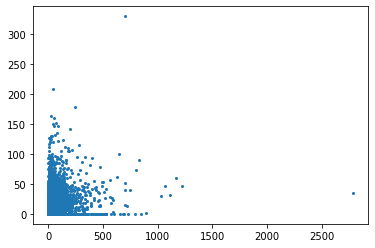

In [0]:
plt.plot(dfp['remove_from_cart'], dfp['purchase'],"o", markersize=2 )
print('remove from cart purchase correlation', dfp['remove_from_cart'].corr(dfp['purchase']))

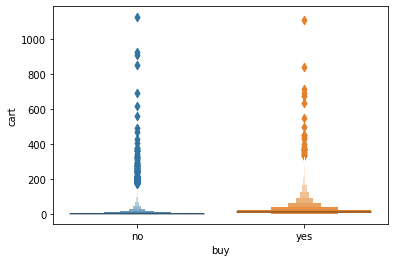

In [0]:
sns.boxenplot('buy', 'cart', data=dfp)
plt.show()

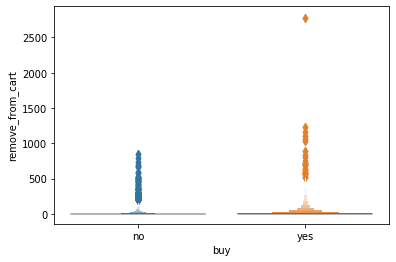

In [0]:
sns.boxenplot('buy', 'remove_from_cart', data=dfp)
plt.show()

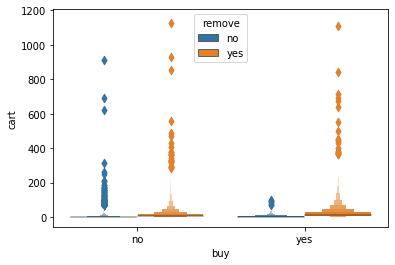

In [0]:
sns.boxenplot('buy', 'cart', hue='remove', data=dfp)
plt.show()

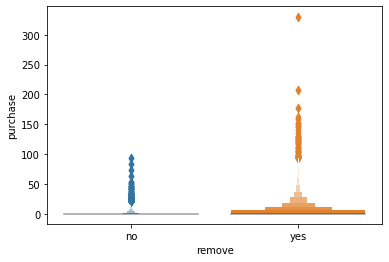

In [0]:
sns.boxenplot('remove', 'purchase', data=dfp)
plt.show()